# EXP08: RFP Corpus EDA
**목표**: 100개 RFP 문서(HWP 93 + PDF 4)의 구조적 특성을 분석하여 일반화 가능한 파이프라인 설계 방향 도출

### 배경
- EXP01~07: 단일 문서(고려대 PDF) 심층 최적화 → KW_v2 0.748 도달, 그러나 table 성능 정체(0.594)
- 단일 문서 과적합 위험: 고려대 PDF 특성에 맞춘 최적화가 다른 문서에서 역효과 가능
- 방향 전환 필요: 전체 corpus를 EDA하여 일반화 가능한 개선 방향 식별

### 실험 구조
| Phase | 내용 | 목적 |
|-------|------|------|
| Phase 0 | 기초 통계 | 파일 크기, 텍스트 길이, 포맷 비율, 추출 성공률 |
| Phase 1 | 구조 분석 | 테이블 수/복잡도, 이미지 수, 섹션 구조 |
| Phase 2 | RFP 도메인 패턴 | 핵심 필드 출현 빈도, 정보 소재(텍스트/표/이미지) |
| Phase 3 | 대표성 검증 | 고려대 PDF vs 전체 분포 비교, 과적합 위험 정량화 |
| Phase 4 | 방향 도출 | 일반화 파이프라인 설계 시사점, 다음 실험 설계 |

### 추출 전략 (3-Layer)
| Layer | HWP (96개) | PDF (4개) |
|-------|-----------|----------|
| L1: 테이블 | hwp5html → `<table>` | pdfplumber `extract_tables()` |
| L2: 이미지 | hwp5html → bindata/ | pdfplumber `page.images` |
| L3: 텍스트 | hwp5txt (fallback: olefile) | pdfplumber `extract_text()` |

In [6]:
# ============================================================
# 1. Setup
# ============================================================
import os
import re
import sys
import json
import time
import shutil
import subprocess
import tempfile
import warnings
from pathlib import Path
from datetime import datetime
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdfplumber
import olefile
from bs4 import BeautifulSoup

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

DATA_DIR = Path('../data/raw/files')
TEMP_DIR = Path('../data/tmp_eda')
OUT_DIR = Path('../data/experiments')
OUT_REPORT = OUT_DIR / 'exp08_eda_report.json'
OUT_CSV = OUT_DIR / 'exp08_eda_results.csv'
OUT_FIG_PREFIX = OUT_DIR / 'exp08'

# 테스트 문서 (지금까지 실험 대상)
TEST_DOC_NAME = '고려대학교_차세대 포털·학사 정보시스템 구축사업.pdf'

all_files = sorted(DATA_DIR.glob('*'))
hwp_files = [f for f in all_files if f.suffix.lower() == '.hwp']
pdf_files = [f for f in all_files if f.suffix.lower() == '.pdf']

print('=' * 60)
print('EXP08: RFP Corpus EDA')
print('=' * 60)
print(f'  Total files: {len(all_files)}')
print(f'  HWP: {len(hwp_files)}')
print(f'  PDF: {len(pdf_files)}')
print(f'  Test doc: {TEST_DOC_NAME}')
print('[OK] Setup complete')

EXP08: RFP Corpus EDA
  Total files: 100
  HWP: 96
  PDF: 4
  Test doc: 고려대학교_차세대 포털·학사 정보시스템 구축사업.pdf
[OK] Setup complete


In [7]:
# ============================================================
# 2. Extraction Functions
# ============================================================

def extract_hwp(hwp_path, temp_base):
    """HWP → hwp5html 변환 → 테이블/이미지/텍스트 추출"""
    result = {
        'file': hwp_path.name, 'format': 'hwp',
        'file_size_kb': hwp_path.stat().st_size / 1024,
        'text_len': 0, 'text': '',
        'n_tables': 0, 'table_details': [],
        'n_images': 0, 'image_details': [],
        'extract_method': 'none', 'error': None,
    }
    
    out_dir = temp_base / hwp_path.stem[:30]  # 폴더명 길이 제한
    out_dir.mkdir(parents=True, exist_ok=True)
    
    # --- L1/L2: hwp5html로 테이블 + 이미지 ---
    try:
        proc = subprocess.run(
            ['hwp5html', '--output', str(out_dir), str(hwp_path)],
            capture_output=True, text=True, timeout=120,
            encoding='utf-8', errors='replace'
        )        
        html_file = out_dir / 'index.xhtml'
        if html_file.exists():
            with open(html_file, 'r', encoding='utf-8', errors='replace') as f:
                soup = BeautifulSoup(f, 'html.parser')
            
            # 테이블 추출
            tables = soup.find_all('table')
            result['n_tables'] = len(tables)
            for ti, tbl in enumerate(tables):
                rows = tbl.find_all('tr')
                cols_per_row = [len(r.find_all(['td', 'th'])) for r in rows]
                max_cols = max(cols_per_row) if cols_per_row else 0
                # 빈 셀 비율 (병합 프록시)
                total_cells = sum(cols_per_row)
                empty_cells = sum(
                    1 for r in rows
                    for c in r.find_all(['td', 'th'])
                    if not c.get_text(strip=True)
                )
                merge_ratio = empty_cells / max(total_cells, 1)
                result['table_details'].append({
                    'rows': len(rows), 'cols': max_cols,
                    'empty_ratio': round(merge_ratio, 3),
                })
            
            # 이미지 추출
            bindata_dir = out_dir / 'bindata'
            if bindata_dir.exists():
                img_files = list(bindata_dir.iterdir())
                result['n_images'] = len(img_files)
                for img in img_files:
                    result['image_details'].append({
                        'name': img.name,
                        'ext': img.suffix.lower(),
                        'size_kb': round(img.stat().st_size / 1024, 1),
                    })
            
            # 텍스트
            text = soup.get_text(separator='\n', strip=True)
            result['text'] = text
            result['text_len'] = len(text)
            result['extract_method'] = 'hwp5html'
    except subprocess.TimeoutExpired:
        result['error'] = 'hwp5html_timeout'
    except Exception as e:
        result['error'] = f'hwp5html: {str(e)[:100]}'
    
    # --- L3 fallback: hwp5txt ---
    if result['text_len'] == 0:
        try:
            proc = subprocess.run(
                ['hwp5txt', str(hwp_path)],
                capture_output=True, text=True, timeout=30,
                encoding='utf-8', errors='replace'
            )
            if proc.returncode == 0 and proc.stdout.strip():
                result['text'] = proc.stdout
                result['text_len'] = len(proc.stdout)
                result['extract_method'] = 'hwp5txt'
        except Exception:
            pass
    
    # --- olefile fallback: BinData 카운트 ---
    if result['n_images'] == 0:
        try:
            ole = olefile.OleFileIO(str(hwp_path))
            bin_streams = [s for s in ole.listdir() if s[0] == 'BinData']
            result['n_images'] = len(bin_streams)
            if result['extract_method'] == 'none':
                result['extract_method'] = 'olefile'
            ole.close()
        except Exception:
            pass
    
    # cleanup
    try:
        shutil.rmtree(out_dir, ignore_errors=True)
    except Exception:
        pass
    
    return result


def extract_pdf(pdf_path):
    """PDF → pdfplumber로 테이블/이미지/텍스트 추출"""
    result = {
        'file': pdf_path.name, 'format': 'pdf',
        'file_size_kb': pdf_path.stat().st_size / 1024,
        'text_len': 0, 'text': '',
        'n_tables': 0, 'table_details': [],
        'n_images': 0, 'image_details': [],
        'n_pages': 0,
        'extract_method': 'pdfplumber', 'error': None,
    }
    
    try:
        pdf = pdfplumber.open(str(pdf_path))
        result['n_pages'] = len(pdf.pages)
        all_text = []
        
        for page in pdf.pages:
            # 텍스트
            text = page.extract_text() or ''
            all_text.append(text)
            
            # 테이블
            tables = page.extract_tables()
            for tbl in tables:
                if not tbl or len(tbl) < 2:
                    continue
                n_rows = len(tbl)
                n_cols = max(len(r) for r in tbl)
                total_cells = sum(len(r) for r in tbl)
                empty_cells = sum(
                    1 for r in tbl for c in r
                    if c is None or (isinstance(c, str) and c.strip() == '')
                )
                merge_ratio = empty_cells / max(total_cells, 1)
                result['table_details'].append({
                    'rows': n_rows, 'cols': n_cols,
                    'empty_ratio': round(merge_ratio, 3),
                })
            
            # 이미지
            if hasattr(page, 'images'):
                result['n_images'] += len(page.images)
        
        result['n_tables'] = len(result['table_details'])
        result['text'] = '\n'.join(all_text)
        result['text_len'] = len(result['text'])
        pdf.close()
    except Exception as e:
        result['error'] = f'pdfplumber: {str(e)[:100]}'
    
    return result


print('[OK] Extraction functions ready')

[OK] Extraction functions ready


---
## Phase 0: 전체 문서 추출 및 기초 통계

In [8]:
# ============================================================
# Phase 0: 전체 문서 일괄 추출
# ============================================================
print('=' * 70)
print('[Phase 0] 전체 문서 추출')
print('=' * 70)

TEMP_DIR.mkdir(parents=True, exist_ok=True)
all_results = []
errors = []

total = len(hwp_files) + len(pdf_files)
for i, f in enumerate(hwp_files + pdf_files):
    if (i + 1) % 10 == 0 or i == 0:
        print(f'  [{i+1}/{total}] {f.name[:50]}...')
    
    if f.suffix.lower() == '.hwp':
        r = extract_hwp(f, TEMP_DIR)
    else:
        r = extract_pdf(f)
    
    all_results.append(r)
    if r['error']:
        errors.append((f.name, r['error']))

# cleanup temp
shutil.rmtree(TEMP_DIR, ignore_errors=True)

df = pd.DataFrame([{
    'file': r['file'],
    'format': r['format'],
    'file_size_kb': round(r['file_size_kb'], 1),
    'text_len': r['text_len'],
    'n_tables': r['n_tables'],
    'n_images': r['n_images'],
    'extract_method': r['extract_method'],
    'error': r['error'],
} for r in all_results])

print(f'\n--- 추출 결과 요약 ---')
print(f'  성공: {len(df[df["error"].isna()])}/{total}')
print(f'  실패: {len(errors)}')
for name, err in errors:
    print(f'    - {name[:50]}: {err}')
print(f'\n  추출 방법 분포:')
print(df['extract_method'].value_counts().to_string(header=False))
print(f'\n[Phase 0] 추출 완료')

[Phase 0] 전체 문서 추출
  [1/100] (사)벤처기업협회_2024년 벤처확인종합관리시스템 기능 고도화 용역사업 .hwp...
  [10/100] 경기도평택시_2024년도 평택시 버스정보시스템(BIS) 구축사업.hwp...
  [20/100] 국민연금공단_2024년 이러닝시스템 운영 용역.hwp...
  [30/100] 대한장애인체육회_2025년 전국장애인체육대회 전산 및 시스템, 홈페이지 .hwp...
  [40/100] 세종테크노파크_세종테크노파크 인사정보 전산시스템 구축 용역 입찰공.hwp...
  [50/100] 재단법인 광주연구원_광주정책연구아카이브(GPA) 시스템 개발.hwp...
  [60/100] 축산물품질평가원_축산물이력관리시스템 개선(정보화 사업).hwp...
  [70/100] 한국발명진흥회 입찰공고_2024년 건설기술에 관한 특허·실용신안 활용실.hwp...
  [80/100] 한국수자원공사_수도사업장 통합 사고분석솔루션 시범구축 용역.hwp...
  [90/100] 한국지식재산보호원_IP-NAVI  해외지식재산센터 사업관리 시스템 기능개.hwp...
  [100/100] 서울특별시_2024년 지도정보 플랫폼 및 전문활용 연계 시스템 고도화 용.pdf...

--- 추출 결과 요약 ---
  성공: 97/100
  실패: 3
    - KOICA 전자조달_[긴급] [지문] [국제] 우즈베키스탄 열린 의정활동 상하원 .hwp: hwp5html_timeout
    - 그랜드코리아레저(주)_2024년도 GKL  그룹웨어 시스템 구축 용역.hwp: hwp5html_timeout
    - 한국철도공사 (용역)_모바일오피스 시스템 고도화 용역(총체 및 1차).hwp: hwp5html_timeout

  추출 방법 분포:
hwp5html      75
hwp5txt       20
pdfplumber     4
olefile        1

[Phase 0] 추출 완료


--- 기초 통계 ---

  파일 크기 (KB):
    mean=1668, median=944, min=144, max=23546

  텍스트 길이 (chars, 추출 성공 98건):
    mean=59,750, median=60,174, min=12,807, max=188,943

  테이블 수:
    mean=96.8, median=104, min=0, max=387
    테이블 0개 문서: 22/100

  이미지 수:
    mean=10.1, median=5, min=0, max=343
    이미지 0개 문서: 1/100


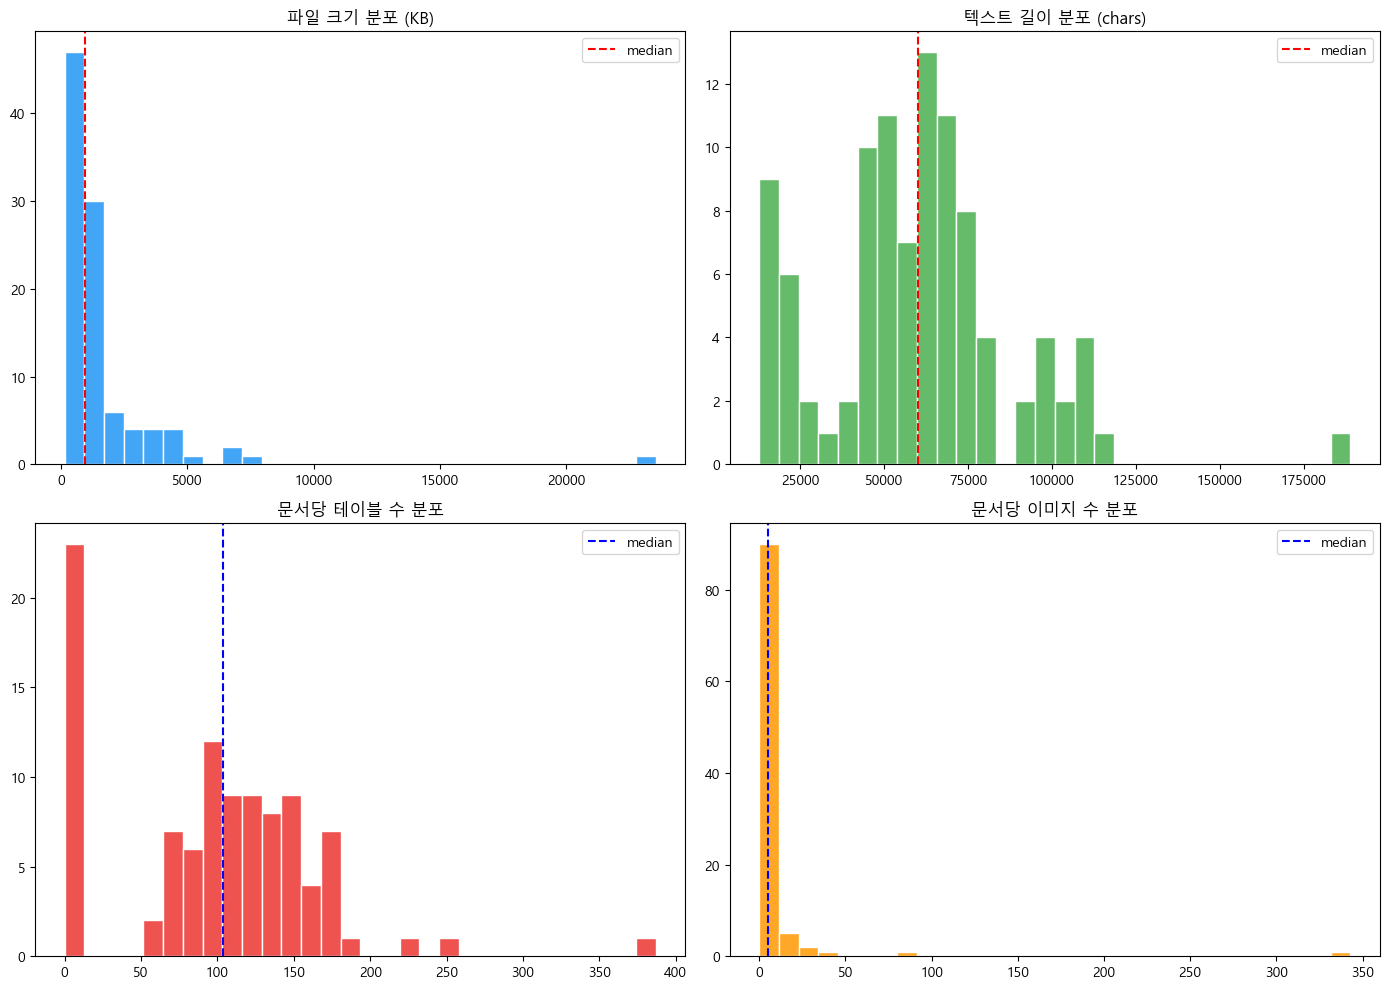

In [9]:
# ============================================================
# Phase 0: 기초 통계
# ============================================================
print('--- 기초 통계 ---')
print(f'\n  파일 크기 (KB):')
print(f'    mean={df["file_size_kb"].mean():.0f}, median={df["file_size_kb"].median():.0f}, '
      f'min={df["file_size_kb"].min():.0f}, max={df["file_size_kb"].max():.0f}')

valid = df[df['text_len'] > 0]
print(f'\n  텍스트 길이 (chars, 추출 성공 {len(valid)}건):')
print(f'    mean={valid["text_len"].mean():,.0f}, median={valid["text_len"].median():,.0f}, '
      f'min={valid["text_len"].min():,.0f}, max={valid["text_len"].max():,.0f}')

print(f'\n  테이블 수:')
print(f'    mean={df["n_tables"].mean():.1f}, median={df["n_tables"].median():.0f}, '
      f'min={df["n_tables"].min()}, max={df["n_tables"].max()}')
print(f'    테이블 0개 문서: {len(df[df["n_tables"]==0])}/{total}')

print(f'\n  이미지 수:')
print(f'    mean={df["n_images"].mean():.1f}, median={df["n_images"].median():.0f}, '
      f'min={df["n_images"].min()}, max={df["n_images"].max()}')
print(f'    이미지 0개 문서: {len(df[df["n_images"]==0])}/{total}')

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax = axes[0, 0]
ax.hist(df['file_size_kb'], bins=30, color='#42A5F5', edgecolor='white')
ax.set_title('파일 크기 분포 (KB)')
ax.axvline(df['file_size_kb'].median(), color='red', linestyle='--', label='median')
ax.legend()

ax = axes[0, 1]
ax.hist(valid['text_len'], bins=30, color='#66BB6A', edgecolor='white')
ax.set_title('텍스트 길이 분포 (chars)')
ax.axvline(valid['text_len'].median(), color='red', linestyle='--', label='median')
ax.legend()

ax = axes[1, 0]
ax.hist(df['n_tables'], bins=30, color='#EF5350', edgecolor='white')
ax.set_title('문서당 테이블 수 분포')
ax.axvline(df['n_tables'].median(), color='blue', linestyle='--', label='median')
ax.legend()

ax = axes[1, 1]
ax.hist(df['n_images'], bins=30, color='#FFA726', edgecolor='white')
ax.set_title('문서당 이미지 수 분포')
ax.axvline(df['n_images'].median(), color='blue', linestyle='--', label='median')
ax.legend()

plt.tight_layout()
plt.savefig(f'{OUT_FIG_PREFIX}_phase0_basic.png', dpi=150, bbox_inches='tight')
plt.show()

## Phase 0 결과 해석

  ### 기초 통계 요약

  | 항목 | 수치 | 의미 |
  |------|------|------|
  | 전체 문서 수 | 100 (HWP 96, PDF 4) | 코퍼스 기준은 100건으로 확정 |
  | 추출 성공률 | 97/100 (97.0%) | 3건 hwp5html timeout 발생 |
  | 실패 원인 | hwp5html_timeout 3건 | HWP 변환 단계 안정성 이슈 확인 |
  | 추출 방법 분포 | hwp5html 75 / hwp5txt 20 / olefile 1 / pdfplumber 4 | HWP 96건 중 21건은 fallback 경로 사용 |
  | 텍스트 유효 추출 | 98/100 | 2건은 텍스트 길이 0 또는 미미 |
  | 파일 크기 (KB) | mean 1,668 / median 944 / min 144 / max 23,546 | 문서 크기 편차 큼 |
  | 텍스트 길이 (chars) | mean 59,750 / median 60,174 / min 12,807 / max 188,943 | 전반적으로 장문 문서 중심 |
  | 테이블 수 | mean 96.8 / median 104 / min 0 / max 387 | 테이블 밀집 문서 비중 높음 |
  | 테이블 0개 문서 | 22/100 | 비테이블 문서군도 일정 비율 존재 |
  | 이미지 수 | mean 10.1 / median 5 / min 0 / max 343 | 이미지 정보도 광범위하게 분포 |
  | 이미지 0개 문서 | 1/100 | 대부분 문서에서 이미지 포함 |

  ### 핵심 발견

  **1. 전체 파이프라인은 동작하지만 HWP 변환 안정성 보완이 필요**
  - 성공률은 97%로 높지만, 실패 3건이 모두 `hwp5html_timeout`에 집중됨.
  - fallback(hwp5txt/olefile)로 상당 부분 보완되나, timeout 제어가 필요함.

  **2. 테이블은 “희소”가 아니라 “핵심 구조”에 가깝다**
  - median 104, mean 96.8은 다수 문서가 테이블 중심 구조임을 시사.
  - 이전 가정(테이블 희소)과 달리, 일반화 파이프라인에서 table-aware 전략은 선택이 아니라 기본축에 가까움.

  **3. 코퍼스는 이질적 혼합 분포다**
  - 테이블 0개 문서 22건 vs 테이블 밀집 문서 다수 → 단일 처리 전략의 한계가 예상됨.
  - 이미지도 거의 전 문서에 존재하여 텍스트-only 접근은 정보 누락 위험이 큼.

  **4. 장문 처리 비용/지연 리스크가 현실적이다**
  - 텍스트 최대 188,943 chars, 파일 최대 23MB급으로 긴 문서 꼬리가 존재.
  - chunking, retrieval budget, timeout 정책을 문서 규모별로 차등화할 필요가 있음.

  ### Phase 1 설계 시사점

  1. **문서 유형 라우팅 필요**: 비테이블(22건)과 테이블 밀집 문서를 분리해 구조 분석.
  2. **table-aware를 기본 실험축으로 격상**: 헤더 계층/병합셀/표 문맥 보존 전략 우선 검증.
  3. **HWP 변환 안정화 과제 명시**: `hwp5html_timeout` 재시도, timeout 상향, fallback 자동 전환 정책 설계.
  4. **장문서 대응 정책 병행**: 문서 길이 구간별 chunk budget, retrieval top-k, 실행 timeout 차등 적용.

---
## Phase 1: 구조 분석
**분석**: 테이블 복잡도, 이미지 특성, 섹션 구조

In [10]:
# ============================================================
# Phase 1-A: 테이블 복잡도 분석
# ============================================================
print('=' * 70)
print('[Phase 1-A] 테이블 복잡도 분석')
print('=' * 70)

# 전체 테이블 통계 수집
all_table_stats = []
for r in all_results:
    for ti, td in enumerate(r['table_details']):
        all_table_stats.append({
            'file': r['file'],
            'format': r['format'],
            'table_idx': ti,
            'rows': td['rows'],
            'cols': td['cols'],
            'empty_ratio': td['empty_ratio'],
            'cells': td['rows'] * td['cols'],
        })

tdf = pd.DataFrame(all_table_stats)
print(f'  총 테이블 수: {len(tdf)}')

if len(tdf) > 0:
    print(f'\n  테이블 크기:')
    print(f'    rows: mean={tdf["rows"].mean():.1f}, median={tdf["rows"].median():.0f}, max={tdf["rows"].max()}')
    print(f'    cols: mean={tdf["cols"].mean():.1f}, median={tdf["cols"].median():.0f}, max={tdf["cols"].max()}')
    
    print(f'\n  빈 셀 비율 (병합 프록시):')
    print(f'    mean={tdf["empty_ratio"].mean():.3f}, median={tdf["empty_ratio"].median():.3f}')
    high_merge = tdf[tdf['empty_ratio'] > 0.3]
    print(f'    빈 셀 비율 > 30%: {len(high_merge)}/{len(tdf)} ({100*len(high_merge)/len(tdf):.1f}%)')
    
    # 복잡도 분류
    def classify_table(row):
        if row['rows'] <= 3 and row['cols'] <= 3:
            return 'simple'
        elif row['empty_ratio'] > 0.3 or row['cols'] > 8:
            return 'complex'
        else:
            return 'medium'
    
    tdf['complexity'] = tdf.apply(classify_table, axis=1)
    print(f'\n  복잡도 분류:')
    for cat in ['simple', 'medium', 'complex']:
        cnt = len(tdf[tdf['complexity'] == cat])
        print(f'    {cat}: {cnt} ({100*cnt/len(tdf):.1f}%)')
    
    # 문서별 복잡도 분포
    doc_complexity = []
    for r in all_results:
        n = r['n_tables']
        if n == 0:
            doc_complexity.append({'file': r['file'], 'category': 'no_tables'})
        else:
            file_tables = tdf[tdf['file'] == r['file']]
            complex_ratio = len(file_tables[file_tables['complexity'] == 'complex']) / n
            if complex_ratio > 0.5:
                doc_complexity.append({'file': r['file'], 'category': 'mostly_complex'})
            elif complex_ratio > 0.2:
                doc_complexity.append({'file': r['file'], 'category': 'mixed'})
            else:
                doc_complexity.append({'file': r['file'], 'category': 'mostly_simple'})
    
    dc_df = pd.DataFrame(doc_complexity)
    print(f'\n  문서 수준 테이블 복잡도:')
    for cat in ['no_tables', 'mostly_simple', 'mixed', 'mostly_complex']:
        cnt = len(dc_df[dc_df['category'] == cat])
        print(f'    {cat}: {cnt} ({100*cnt/len(dc_df):.1f}%)')

[Phase 1-A] 테이블 복잡도 분석
  총 테이블 수: 9676

  테이블 크기:
    rows: mean=7.1, median=5, max=132
    cols: mean=4.4, median=3, max=290

  빈 셀 비율 (병합 프록시):
    mean=0.184, median=0.015
    빈 셀 비율 > 30%: 2831/9676 (29.3%)

  복잡도 분류:
    simple: 2423 (25.0%)
    medium: 5247 (54.2%)
    complex: 2006 (20.7%)

  문서 수준 테이블 복잡도:
    no_tables: 22 (22.0%)
    mostly_simple: 48 (48.0%)
    mixed: 28 (28.0%)
    mostly_complex: 2 (2.0%)


In [11]:
# ============================================================
# Phase 1-B: 이미지 분석
# ============================================================
print('\n' + '=' * 70)
print('[Phase 1-B] 이미지 분석')
print('=' * 70)

all_img_stats = []
for r in all_results:
    for img in r['image_details']:
        all_img_stats.append({
            'file': r['file'],
            'img_name': img['name'],
            'ext': img['ext'],
            'size_kb': img['size_kb'],
        })

idf = pd.DataFrame(all_img_stats) if all_img_stats else pd.DataFrame()

docs_with_images = len([r for r in all_results if r['n_images'] > 0])
print(f'  이미지 보유 문서: {docs_with_images}/{total} ({100*docs_with_images/total:.1f}%)')
print(f'  총 이미지 수: {sum(r["n_images"] for r in all_results)}')

if len(idf) > 0:
    print(f'\n  이미지 파일 타입:')
    print(idf['ext'].value_counts().to_string(header=False))
    
    print(f'\n  이미지 크기 (KB):')
    print(f'    mean={idf["size_kb"].mean():.1f}, median={idf["size_kb"].median():.1f}, max={idf["size_kb"].max():.1f}')
    
    # 크기별 분류: 작은 이미지(아이콘/로고) vs 정보성 이미지
    small = idf[idf['size_kb'] < 5]
    medium = idf[(idf['size_kb'] >= 5) & (idf['size_kb'] < 50)]
    large = idf[idf['size_kb'] >= 50]
    print(f'\n  크기별 분류:')
    print(f'    < 5KB (아이콘/로고): {len(small)} ({100*len(small)/len(idf):.1f}%)')
    print(f'    5~50KB (소형 도표): {len(medium)} ({100*len(medium)/len(idf):.1f}%)')
    print(f'    >= 50KB (정보성 이미지): {len(large)} ({100*len(large)/len(idf):.1f}%)')
    
    # 정보성 이미지를 가진 문서 수
    large_img_docs = idf[idf['size_kb'] >= 50]['file'].nunique()
    print(f'\n  정보성 이미지(>=50KB) 보유 문서: {large_img_docs}/{total}')


[Phase 1-B] 이미지 분석
  이미지 보유 문서: 99/100 (99.0%)
  총 이미지 수: 1006

  이미지 파일 타입:
.bmp     197
.jpg     118
.png      62
.jpeg      4
.wmf       3
.gif       1

  이미지 크기 (KB):
    mean=831.4, median=196.1, max=12150.1

  크기별 분류:
    < 5KB (아이콘/로고): 29 (7.5%)
    5~50KB (소형 도표): 84 (21.8%)
    >= 50KB (정보성 이미지): 272 (70.6%)

  정보성 이미지(>=50KB) 보유 문서: 70/100


In [12]:
# ============================================================
# Phase 1-C: 섹션 구조 분석 (RFP 공통 섹션 패턴)
# ============================================================
print('\n' + '=' * 70)
print('[Phase 1-C] 섹션 구조 분석')
print('=' * 70)

# RFP 공통 섹션 키워드
SECTION_PATTERNS = {
    '사업개요': r'사업\s*개요|사업\s*목적|과업\s*개요',
    '사업범위': r'사업\s*범위|과업\s*범위|과업\s*내용',
    '추진일정': r'추진\s*일정|사업\s*기간|수행\s*기간',
    '예산': r'사업\s*예산|사업\s*비|사업\s*금액|계약\s*금액',
    '입찰조건': r'입찰\s*조건|입찰\s*자격|참가\s*자격',
    '평가기준': r'평가\s*기준|기술\s*평가|배점\s*기준|심사\s*기준',
    '제안요청': r'제안\s*요청|제안서\s*작성|제안서\s*규격',
    '계약조건': r'계약\s*조건|계약\s*사항|일반\s*조건',
    '하자보수': r'하자\s*보수|유지\s*보수|무상\s*유지',
    '보안': r'보안\s*요구|보안\s*사항|정보\s*보호',
    '시스템구성': r'시스템\s*구성|시스템\s*아키텍처|구성\s*도',
    '요구사항': r'요구\s*사항|기능\s*요구|비기능\s*요구',
}

section_presence = defaultdict(int)
doc_sections = []

for r in all_results:
    text = r['text'][:50000]  # 앞부분만 검사 (성능)
    found = []
    for sec_name, pattern in SECTION_PATTERNS.items():
        if re.search(pattern, text):
            section_presence[sec_name] += 1
            found.append(sec_name)
    doc_sections.append({
        'file': r['file'],
        'n_sections': len(found),
        'sections': found,
    })

print(f'\n  RFP 섹션 출현 빈도 (전체 {total}개 문서):')
for sec, cnt in sorted(section_presence.items(), key=lambda x: x[1], reverse=True):
    bar = '#' * int(cnt / total * 40)
    print(f'    {sec:<12s}: {cnt:>3d}/{total} ({100*cnt/total:>5.1f}%) {bar}')

sec_df = pd.DataFrame(doc_sections)
print(f'\n  문서당 섹션 수:')
print(f'    mean={sec_df["n_sections"].mean():.1f}, median={sec_df["n_sections"].median():.0f}, '
      f'min={sec_df["n_sections"].min()}, max={sec_df["n_sections"].max()}')


[Phase 1-C] 섹션 구조 분석

  RFP 섹션 출현 빈도 (전체 100개 문서):
    추진일정        :  98/100 ( 98.0%) #######################################
    보안          :  97/100 ( 97.0%) ######################################
    요구사항        :  97/100 ( 97.0%) ######################################
    제안요청        :  96/100 ( 96.0%) ######################################
    사업범위        :  95/100 ( 95.0%) ######################################
    예산          :  95/100 ( 95.0%) ######################################
    평가기준        :  94/100 ( 94.0%) #####################################
    하자보수        :  92/100 ( 92.0%) ####################################
    입찰조건        :  92/100 ( 92.0%) ####################################
    시스템구성       :  90/100 ( 90.0%) ####################################
    계약조건        :  88/100 ( 88.0%) ###################################
    사업개요        :  87/100 ( 87.0%) ##################################

  문서당 섹션 수:
    mean=11.2, median=12, min=0, max=12


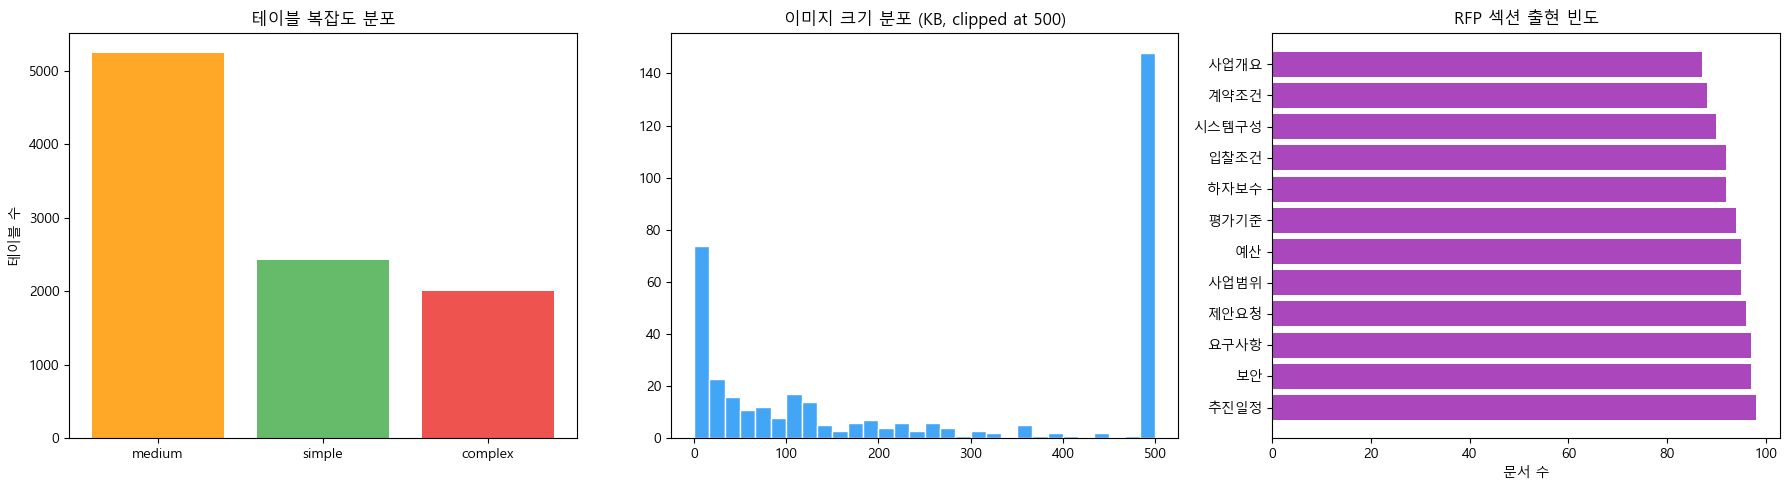

In [13]:
# Phase 1 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) 테이블 복잡도 분포
ax = axes[0]
if len(tdf) > 0:
    cats = tdf['complexity'].value_counts()
    colors = {'simple': '#66BB6A', 'medium': '#FFA726', 'complex': '#EF5350'}
    ax.bar(cats.index, cats.values, color=[colors.get(c, '#90A4AE') for c in cats.index])
ax.set_title('테이블 복잡도 분포')
ax.set_ylabel('테이블 수')

# (b) 이미지 크기 분포
ax = axes[1]
if len(idf) > 0:
    ax.hist(idf['size_kb'].clip(upper=500), bins=30, color='#42A5F5', edgecolor='white')
ax.set_title('이미지 크기 분포 (KB, clipped at 500)')

# (c) 섹션 출현 빈도
ax = axes[2]
sec_sorted = sorted(section_presence.items(), key=lambda x: x[1], reverse=True)
ax.barh([s[0] for s in sec_sorted], [s[1] for s in sec_sorted], color='#AB47BC')
ax.set_title('RFP 섹션 출현 빈도')
ax.set_xlabel('문서 수')

plt.tight_layout()
plt.savefig(f'{OUT_FIG_PREFIX}_phase1_structure.png', dpi=150, bbox_inches='tight')
plt.show()

## Phase 1 결과 해석

### 구조 분석 요약

| 항목 | 수치 | 의미 |
|------|------|------|
| 총 테이블 수 | 9,676 | 코퍼스 전반이 테이블 중심 문서 구조를 가짐 |
| 테이블 행/열 | rows mean 7.1 (median 5, max 132) / cols mean 4.4 (median 3, max 290) | 소형 표가 다수지만 초대형 표(outlier)도 존재 |
| 빈 셀 비율(병합 프록시) | mean 0.184 / median 0.015 / >30% 비율 29.3% (2,831/9,676) | 병합/희소 구조 테이블이 대규모로 존재 |
| 테이블 복잡도 | simple 25.0% / medium 54.2% / complex 20.7% | 중복잡도 이상이 74.9%로 단순 파싱 한계 |
| 문서 수준 복잡도 | no_tables 22 / mostly_simple 48 / mixed 28 / mostly_complex 2 | 문서 유형이 뚜렷하게 분화됨 |
| 이미지 보유 문서 | 99/100 (99.0%) | 이미지 기반 정보가 사실상 기본 구성요소 |
| 총 이미지 수 | 1,006 | 문서당 평균 10.1개 수준의 시각 정보 포함 |
| 정보성 이미지 비율 | >=50KB 272개 (70.6%), 보유 문서 70/100 | OCR/이미지 이해 파이프라인 필요성 높음 |
| 섹션 출현 빈도 상위 | 추진일정 98%, 보안/요구사항 97%, 제안요청 96%, 사업범위/예산 95% | 도메인 공통 템플릿이 강함 |
| 문서당 섹션 수 | mean 11.2 / median 12 (max 12) | 대부분 문서가 거의 완전한 RFP 섹션 세트를 포함 |

### 핵심 발견

**1. 테이블은 핵심 정보 저장소다**
- Phase 0 보정 결과와 일치하게, 총 9,676개 테이블이 확인됨.
- 단순 텍스트 청킹만으로는 표 내부 관계(행/열/병합) 손실 가능성이 높다.

**2. 테이블 복잡도는 “중간 이상”이 기본값이다**
- medium+complex가 74.9%, 빈 셀 비율 >30%가 29.3%로 높다.
- 헤더 계층/병합 셀 상속을 처리하지 않으면 검색/추출 정확도 저하가 구조적으로 발생한다.

**3. 이미지 정보도 1차 처리 대상이다**
- 문서의 99%가 이미지를 포함하고, 정보성 이미지(>=50KB)가 70개 문서에서 확인됨.
- 표/텍스트만 최적화해도 전체 일반화 성능 상한이 제한될 가능성이 크다.

**4. 섹션 구조는 높은 표준성을 가진다**
- 핵심 섹션이 90% 이상 빈도로 반복되어 섹션 기반 라우팅/가중치 전략의 효과가 기대된다.
- 즉, retrieval에서 section prior를 주는 방식이 일반화에 유리하다.

### Phase 2 설계 시사점

1. **정보 소재 라우팅 필수**: 질문을 `text/table/image`로 먼저 분류하고, 소재별 검색 경로를 분리.
2. **table-aware 검색 고도화**: 행/열 헤더 경로(`col_path`) 보존 + 병합 셀 상속 규칙을 기본 적용.
3. **이미지 대응 실험 추가**: OCR + 캡션/도표 요약 인덱싱을 최소 baseline으로 포함.
4. **섹션 priors 활용**: `추진일정/예산/평가기준/보안` 등 고빈도 섹션에 retrieval boost를 적용해 상위 랭킹 안정화.

---
## Phase 2: RFP 도메인 패턴 분석
**분석**: 핵심 필드별 정보 소재(텍스트 vs 표 vs 이미지), 표현 패턴

In [14]:
# ============================================================
# Phase 2: 핵심 필드 정보 소재 분석
# ============================================================
print('=' * 70)
print('[Phase 2] 핵심 필드 정보 소재 분석')
print('=' * 70)

# BidFlow 추출 대상 핵심 필드 + 검색 패턴
KEY_FIELDS = {
    '사업명': [r'사업\s*명', r'용역\s*명', r'과업\s*명'],
    '발주기관': [r'발주\s*기관', r'발주처', r'수요\s*기관'],
    '사업기간': [r'사업\s*기간', r'수행\s*기간', r'계약\s*기간', r'용역\s*기간'],
    '사업예산': [r'사업\s*예산', r'사업\s*비', r'추정\s*가격', r'계약\s*금액', r'예정\s*가격'],
    '입찰자격': [r'입찰\s*자격', r'참가\s*자격', r'참여\s*자격'],
    '평가배점': [r'배점', r'기술\s*평가.*점', r'평가\s*항목.*배점'],
    '납품장소': [r'납품\s*장소', r'설치\s*장소', r'수행\s*장소'],
    '하자보수기간': [r'하자\s*보수\s*기간', r'무상\s*유지\s*보수', r'무상\s*보수'],
    '지급조건': [r'지급\s*조건', r'대가\s*지급', r'대금\s*지급', r'기성\s*지급'],
    '보안등급': [r'보안\s*등급', r'보안\s*요구', r'보안\s*수준'],
}


def check_field_in_tables(all_result, field_patterns):
    """테이블 텍스트 내 필드 존재 여부"""
    for td in all_result['table_details']:
        # table_details에 텍스트가 없으면 본문 텍스트로 대체
        pass
    return False


field_stats = []
for r in all_results:
    text = r['text']
    if not text:
        continue
    
    for field_name, patterns in KEY_FIELDS.items():
        found = any(re.search(p, text) for p in patterns)
        field_stats.append({
            'file': r['file'],
            'field': field_name,
            'found': found,
        })

fdf = pd.DataFrame(field_stats)
print(f'\n  핵심 필드 출현 빈도 (텍스트 추출 성공 문서):')
n_valid = fdf['file'].nunique()
for field in KEY_FIELDS.keys():
    cnt = fdf[(fdf['field'] == field) & (fdf['found'])]['file'].nunique()
    bar = '#' * int(cnt / max(n_valid, 1) * 40)
    print(f'    {field:<12s}: {cnt:>3d}/{n_valid} ({100*cnt/max(n_valid,1):>5.1f}%) {bar}')

# 문서당 발견 필드 수
doc_field_counts = fdf[fdf['found']].groupby('file').size()
print(f'\n  문서당 발견 필드 수:')
print(f'    mean={doc_field_counts.mean():.1f}, median={doc_field_counts.median():.0f}, '
      f'min={doc_field_counts.min()}, max={doc_field_counts.max()}')

[Phase 2] 핵심 필드 정보 소재 분석

  핵심 필드 출현 빈도 (텍스트 추출 성공 문서):
    사업명         :  80/98 ( 81.6%) ################################
    발주기관        :  94/98 ( 95.9%) ######################################
    사업기간        :  97/98 ( 99.0%) #######################################
    사업예산        :  97/98 ( 99.0%) #######################################
    입찰자격        :  97/98 ( 99.0%) #######################################
    평가배점        :  93/98 ( 94.9%) #####################################
    납품장소        :  58/98 ( 59.2%) #######################
    하자보수기간      :  56/98 ( 57.1%) ######################
    지급조건        :  48/98 ( 49.0%) ###################
    보안등급        :  92/98 ( 93.9%) #####################################

  문서당 발견 필드 수:
    mean=8.4, median=9, min=3, max=10


In [15]:
# ============================================================
# Phase 2-B: 금액/수치 표현 패턴 분석
# ============================================================
print('\n' + '=' * 70)
print('[Phase 2-B] 금액/수치 표현 패턴 분석')
print('=' * 70)

AMOUNT_PATTERNS = {
    '원': r'\d[\d,]*\s*원',
    '만원': r'\d[\d,]*\s*만\s*원',
    '백만원': r'\d[\d,]*\s*백만\s*원',
    '억원': r'\d[\d,]*\s*억\s*원',
    '%': r'\d+\.?\d*\s*%',
    '일/개월/년': r'\d+\s*(일|개월|년|년간)',
    'VAT포함': r'[Vv][Aa][Tt]\s*포함|부가세\s*포함',
    'VAT별도': r'[Vv][Aa][Tt]\s*별도|부가세\s*별도',
}

amount_stats = defaultdict(int)
for r in all_results:
    text = r['text']
    if not text:
        continue
    for pat_name, pattern in AMOUNT_PATTERNS.items():
        matches = re.findall(pattern, text)
        if matches:
            amount_stats[pat_name] += 1

print(f'\n  금액/수치 표현 패턴 (출현 문서 수):')
for pat_name, cnt in sorted(amount_stats.items(), key=lambda x: x[1], reverse=True):
    print(f'    {pat_name:<12s}: {cnt:>3d}/{total} ({100*cnt/total:.1f}%)')


[Phase 2-B] 금액/수치 표현 패턴 분석

  금액/수치 표현 패턴 (출현 문서 수):
    일/개월/년      :  98/100 (98.0%)
    %           :  96/100 (96.0%)
    원           :  68/100 (68.0%)
    VAT포함       :  68/100 (68.0%)
    억원          :  67/100 (67.0%)
    만원          :  26/100 (26.0%)
    백만원         :  14/100 (14.0%)
    VAT별도       :   2/100 (2.0%)


## Phase 2 결과 해석

### 도메인 패턴 분석 요약

| 항목 | 수치 | 의미 |
|------|------|------|
| 분석 대상(필드) | 텍스트 유효 추출 98문서 | 필드 출현 빈도는 98문서 기준 |
| 문서당 발견 필드 수 | mean 8.4 / median 9 / min 3 / max 10 | 대부분 문서가 핵심 필드를 다수 포함 |
| 고출현 필드(>=93%) | 사업기간 99.0%, 사업예산 99.0%, 입찰자격 99.0%, 발주기관 95.9%, 평가배점 94.9%, 보안등급 93.9% | 공통 메타 스키마로 표준화 가능 |
| 중간 출현 필드 | 사업명 81.6% | 표기 변형/문서 스타일 차이 영향 가능 |
| 저출현 필드(<60%) | 납품장소 59.2%, 하자보수기간 57.1%, 지급조건 49.0% | 문서별 선택 기재 항목 가능성 큼 |
| 수치 패턴 상위 | 기간(일/개월/년) 98.0%, 퍼센트 96.0% | 기간/비율 정보 추출 중요 |
| 금액 패턴 | 원 68.0%, 억원 67.0%, 만원 26.0%, 백만원 14.0% | 금액 단위 표기가 혼재 |
| VAT 패턴 | VAT포함 68.0%, VAT별도 2.0% | 금액 정규화 시 `포함/별도` 구분 필수 |

### 핵심 발견

**1. RFP 핵심 필드는 높은 공통성을 가진다**
- 상위 6개 필드가 93~99% 수준으로 출현하여, 일반화 파이프라인의 기본 추출 타깃으로 충분히 안정적이다.
- 문서당 필드 수 median=9는 “핵심 10필드 스키마” 접근이 현실적임을 보여준다.

**2. 일부 필드는 선택적/문맥 의존적이다**
- `납품장소/하자보수기간/지급조건`은 50% 내외로, 누락을 오류로 단정하면 오탐이 증가할 수 있다.
- 이들 필드는 “옵션 필드(optional)”로 설계하고, 미검출 시 근거 텍스트 부재를 함께 리포팅하는 방식이 적합하다.

**3. 수치 정보는 기간·비율·금액의 혼합 정규화가 핵심이다**
- 기간/비율 패턴은 거의 보편적(96~98%)이고, 금액은 단위가 `원/만원/백만원/억원`으로 분산된다.
- 따라서 수치 후처리는 단순 숫자 추출이 아니라 **단위 통일 + VAT 포함/별도 태깅**까지 포함해야 한다.

**4. 금액 해석에서 VAT 정책이 결과를 좌우한다**
- `VAT포함` 표기가 68%로 높아 실무형 금액 질의에서 세전/세후 혼동 위험이 크다.
- 추출 결과 스키마에 `amount_value`, `amount_unit`, `vat_flag(included/excluded/unknown)`를 분리 저장할 필요가 있다.

### Phase 3 설계 시사점

1. **대표성 검증 기준 필드 선정**: 고출현 필드(사업기간/예산/입찰자격/발주기관/평가배점/보안등급)를 core KPI로 사용.
2. **옵션 필드 평가 규칙 분리**: 납품장소/하자보수/지급조건은 presence-aware(존재 시만 채점) 방식 적용.
3. **수치 정규화 벤치마크 추가**: 금액 단위 환산 정확도 + VAT 포함/별도 분류 정확도를 별도 지표로 관리.
4. **스키마 고정안 도출**: Phase 4에서 core/optional 필드 2계층 출력 포맷으로 일반화 파이프라인 초안 확정.

---
## Phase 3: 대표성 검증
**분석**: 고려대 PDF(테스트 문서)가 전체 corpus에서 어떤 위치에 있는지

[Phase 3] 대표성 검증

  테스트 문서: 고려대학교_차세대 포털·학사 정보시스템 구축사업.pdf

  Metric                  테스트        중앙값      백분위     판정
  --------------------------------------------------------
  파일 크기(KB)              7090        944    97.0%     극단
  텍스트 길이               188943      59486    99.0%     극단
  테이블 수                   387        104    99.0%     극단
  이미지 수                   343          5    99.0%     극단


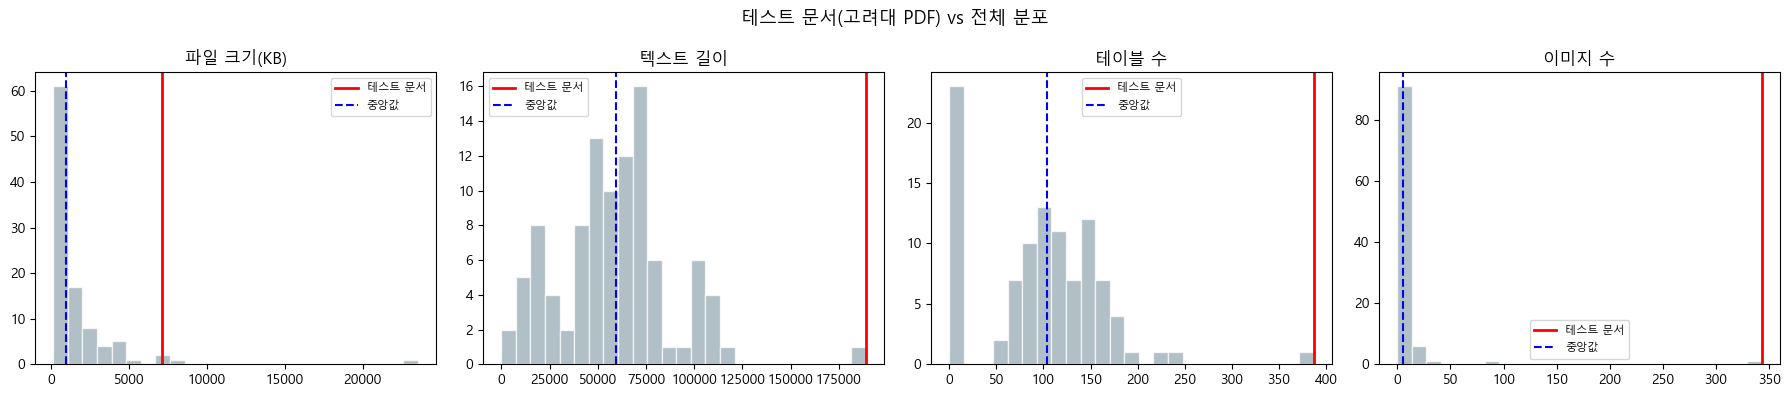


  과적합 위험 점수: 4/4 지표가 극단값
  ⚠️  테스트 문서가 corpus를 대표하지 못할 위험 높음


In [16]:
# ============================================================
# Phase 3: 대표성 검증
# ============================================================
print('=' * 70)
print('[Phase 3] 대표성 검증')
print('=' * 70)

# 테스트 문서 통계
test_row = df[df['file'] == TEST_DOC_NAME]
if len(test_row) == 0:
    # 파일명 부분 매칭
    test_row = df[df['file'].str.contains('고려대', na=False)]

if len(test_row) > 0:
    test = test_row.iloc[0]
    print(f'\n  테스트 문서: {test["file"]}')
    
    metrics = ['file_size_kb', 'text_len', 'n_tables', 'n_images']
    metric_names = ['파일 크기(KB)', '텍스트 길이', '테이블 수', '이미지 수']
    
    print(f'\n  {"Metric":<16s} {"테스트":>10s} {"중앙값":>10s} {"백분위":>8s} {"판정":>6s}')
    print(f'  ' + '-' * 56)
    
    percentiles = {}
    for metric, name in zip(metrics, metric_names):
        test_val = test[metric]
        med = df[metric].median()
        pct = (df[metric] < test_val).mean() * 100
        percentiles[metric] = pct
        
        if 25 <= pct <= 75:
            judge = '대표적'
        elif 10 <= pct <= 90:
            judge = '편향'
        else:
            judge = '극단'
        
        print(f'  {name:<16s} {test_val:>10.0f} {med:>10.0f} {pct:>7.1f}% {judge:>6s}')
    
    # 시각화
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    for ax, metric, name in zip(axes, metrics, metric_names):
        data = df[metric].dropna()
        ax.hist(data, bins=25, color='#90A4AE', edgecolor='white', alpha=0.7)
        ax.axvline(test[metric], color='red', linewidth=2, label=f'테스트 문서')
        ax.axvline(data.median(), color='blue', linestyle='--', label='중앙값')
        ax.set_title(name)
        ax.legend(fontsize=8)
    
    plt.suptitle('테스트 문서(고려대 PDF) vs 전체 분포', fontsize=13)
    plt.tight_layout()
    plt.savefig(f'{OUT_FIG_PREFIX}_phase3_representativeness.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 과적합 위험 점수
    extreme_count = sum(1 for p in percentiles.values() if p < 10 or p > 90)
    print(f'\n  과적합 위험 점수: {extreme_count}/4 지표가 극단값')
    if extreme_count >= 2:
        print(f'  ⚠️  테스트 문서가 corpus를 대표하지 못할 위험 높음')
    elif extreme_count == 1:
        print(f'  ⚡ 일부 지표에서 편향 존재, 주의 필요')
    else:
        print(f'  ✓ 테스트 문서가 corpus를 비교적 잘 대표함')
else:
    print(f'  ⚠️ 테스트 문서를 찾을 수 없음: {TEST_DOC_NAME}')

In [17]:
# ============================================================
# Phase 3-B: HWP vs PDF 구조 차이
# ============================================================
print('\n' + '=' * 70)
print('[Phase 3-B] HWP vs PDF 구조 차이')
print('=' * 70)

for fmt in ['hwp', 'pdf']:
    subset = df[df['format'] == fmt]
    print(f'\n  [{fmt.upper()}] (n={len(subset)})')
    for col in ['file_size_kb', 'text_len', 'n_tables', 'n_images']:
        vals = subset[col]
        print(f'    {col:<15s}: mean={vals.mean():>10.1f}, med={vals.median():>10.1f}, '
              f'min={vals.min():>8.0f}, max={vals.max():>8.0f}')

print(f'\n  ⚠️ PDF는 4건뿐이므로 통계적 비교는 참고용')


[Phase 3-B] HWP vs PDF 구조 차이

  [HWP] (n=96)
    file_size_kb   : mean=    1602.1, med=     934.5, min=     144, max=   23546
    text_len       : mean=   56221.2, med=   58656.0, min=       0, max=  111630
    n_tables       : mean=      92.8, med=     103.0, min=       0, max=     246
    n_images       : mean=       6.0, med=       5.0, min=       0, max=      85

  [PDF] (n=4)
    file_size_kb   : mean=    3259.1, med=    2659.7, min=     627, max=    7090
    text_len       : mean=  114561.8, med=  112113.0, min=   45078, max=  188943
    n_tables       : mean=     190.8, med=     161.0, min=      54, max=     387
    n_images       : mean=     106.8, med=      31.5, min=      21, max=     343

  ⚠️ PDF는 4건뿐이므로 통계적 비교는 참고용


## Phase 3 결과 해석

### 대표성 검증 요약

| 항목 | 테스트 문서(고려대 PDF) | 코퍼스 기준(중앙값/분포) | 판정 |
|------|-------------------------|---------------------------|------|
| 파일 크기 (KB) | 7,090 | 중앙값 944 / 백분위 97.0% | 극단 |
| 텍스트 길이 (chars) | 188,943 | 중앙값 59,486 / 백분위 99.0% | 극단 |
| 테이블 수 | 387 | 중앙값 104 / 백분위 99.0% | 극단 |
| 이미지 수 | 343 | 중앙값 5 / 백분위 99.0% | 극단 |
| 과적합 위험 점수 | 4/4 지표 극단값 | - | 높음 |

### HWP vs PDF 구조 차이 요약 (참고)

| 포맷 | n | text_len mean/median | n_tables mean/median | n_images mean/median |
|------|---|----------------------|----------------------|----------------------|
| HWP | 96 | 56,221 / 58,656 | 92.8 / 103.0 | 6.0 / 5.0 |
| PDF | 4 | 114,561.8 / 112,113.0 | 190.8 / 161.0 | 106.8 / 31.5 |

> 주의: PDF 샘플 수가 4건으로 작아 포맷 간 차이는 경향성 수준으로 해석.

### 핵심 발견

**1. 기존 테스트 문서(고려대 PDF)는 코퍼스 대표성이 매우 낮다**
- 파일 크기, 텍스트 길이, 테이블 수, 이미지 수가 모두 상위 97~99 백분위.
- 단일 문서 기준 최적화 결과를 전체 코퍼스로 일반화하면 성능 과대추정 위험이 크다.

**2. 과거 실험의 “성공 조건”이 특수 케이스에 편향되었을 가능성**
- 고려대 문서는 장문+고테이블+고이미지 복합 구조로 난도가 높고 특이성이 크다.
- 해당 문서에서 효과적이던 파라미터(청킹/컷/검색 조합)는 일반 HWP 문서군에서 비효율일 수 있다.

**3. 포맷별 구조 차이가 커 단일 파이프라인 고정값 전략은 한계가 있다**
- HWP 대비 PDF는 평균적으로 텍스트/테이블/이미지 규모가 모두 크다.
- 특히 이미지 규모 차이(n_images mean 6.0 vs 106.8)는 처리 경로 분리가 필요함을 시사한다.

### Phase 4 설계 시사점

1. **대표성 기반 평가셋 재구성**: 백분위 구간별(중앙부/상위 tail) 문서를 균형 샘플링.
2. **문서 유형 라우팅 도입**: `일반형(HWP 중심)` vs `대용량 PDF형`으로 파이프라인 분기.
3. **성능 보고 체계 이원화**: 전체 평균 + tail 문서 전용 지표를 병행해 과적합 착시 방지.
4. **기존 실험 재해석 필요**: EXP01~07의 개선치는 “고려대 유사군”과 “전체군”으로 분리 보고.

---
## Phase 4: 종합 및 방향 도출

In [18]:
# ============================================================
# Phase 4: 보고서 저장
# ============================================================

# 직렬화 가능한 형태로 정리
report = {
    'experiment': 'EXP08: RFP Corpus EDA',
    'timestamp': datetime.now().isoformat(),
    'corpus': {
        'total_files': total,
        'hwp_count': len(hwp_files),
        'pdf_count': len(pdf_files),
        'extraction_success': int(len(df[df['error'].isna()])),
        'extraction_errors': len(errors),
    },
    'basic_stats': {
        'file_size_kb': {
            'mean': round(df['file_size_kb'].mean(), 1),
            'median': round(df['file_size_kb'].median(), 1),
        },
        'text_len': {
            'mean': int(valid['text_len'].mean()) if len(valid) > 0 else 0,
            'median': int(valid['text_len'].median()) if len(valid) > 0 else 0,
        },
        'n_tables': {
            'mean': round(df['n_tables'].mean(), 1),
            'median': int(df['n_tables'].median()),
            'zero_count': int(len(df[df['n_tables'] == 0])),
        },
        'n_images': {
            'mean': round(df['n_images'].mean(), 1),
            'median': int(df['n_images'].median()),
            'zero_count': int(len(df[df['n_images'] == 0])),
        },
    },
    'table_analysis': {
        'total_tables': len(tdf) if len(tdf) > 0 else 0,
        'complexity_dist': tdf['complexity'].value_counts().to_dict() if len(tdf) > 0 else {},
    },
    'section_presence': dict(section_presence),
}

with open(OUT_REPORT, 'w', encoding='utf-8') as f:
    json.dump(report, f, indent=2, ensure_ascii=False)

df.to_csv(OUT_CSV, index=False, encoding='utf-8-sig')

print(f'  Report: {OUT_REPORT}')
print(f'  CSV: {OUT_CSV}')

  Report: ..\data\experiments\exp08_eda_report.json
  CSV: ..\data\experiments\exp08_eda_results.csv


### 종합 진단 요약

| 관점 | Phase별 근거 | 종합 판단 |
|------|--------------|-----------|
| 데이터 품질/안정성 | Phase 0: 추출 성공 97/100, 실패 3건 모두 `hwp5html_timeout` | 정확도 이전에 운영 안정성(ingestion) 보강 필요 |
| 구조 복잡도 | Phase 1: 총 테이블 9,676, medium+complex 74.9%, 이미지 보유 99/100 | 텍스트-only 파이프라인으로는 구조 손실 불가피 |
| 도메인 공통성 | Phase 2: 핵심 필드 6종이 93~99% 출현, 문서당 필드 median 9 | core schema 표준화 + optional schema 분리가 타당 |
| 일반화 리스크 | Phase 3: 고려대 PDF 4/4 지표 극단(97~99 백분위) | 단일 문서 최적화는 worst-group 성능 붕괴 위험 큼 |

### 방향 도출 (Generalization Blueprint)

**1. 라우팅을 결정론적/관측가능하게 설계**
- 업로드 직후 `doc_fingerprint`(format, text_len, table_density, image_ratio, parse_fail_type)를 생성/저장.
- 라우팅 결과는 반드시 로그(`route`, `route_score`, `reason`)로 남겨 재현성과 디버깅 가능성을 확보.

**2. 불확실 구간은 단일 경로 대신 다중 경로 허용**
- 확신도가 낮으면 `text + table` 또는 `text + image`를 동시 실행 후 rerank.
- 잘못된 단일 라우팅으로 인한 전량 실패 리스크를 완화.

**3. 출력 스키마는 core/optional + provenance를 기본값으로 채택**
- Core(강제): 사업기간, 사업예산, 입찰자격, 발주기관, 평가배점, 보안등급.
- Optional(조건부): 납품장소, 하자보수기간, 지급조건.
- 필드별 provenance(page, section_path, table_id/cell_path)를 함께 저장해 Faithfulness 역추적 가능성 확보.

**4. 평가 체계를 평균 중심에서 worst-group 중심으로 확장**
- 보고 지표: `overall mean` + `macro(group mean)` + `worst-group`를 동시 보고.
- 중앙군이 평균을 덮어 tail 실패를 숨기는 문제를 방지.

### 다음 실험(Exp09) 실행안 (피드백 반영)

1. **Dataset Split 재정의 (복합 난이도 스코어)**
- 극단군을 단일 지표가 아닌 `text_len + table_density + image_ratio + timeout_risk` 복합 점수로 정의.
- `중앙군/극단군` 균형 샘플링 후 동일 질문셋 구조로 평가.

2. **Routing Ablation 3단 비교**
- A: 단일 파이프라인(기존)
- B: 규칙 기반 단일 라우팅
- C: 규칙 + 불확실 구간 다중 라우팅(2경로 실행 후 rerank)

3. **Table/Image 2x2는 전체 평균이 아닌 그룹별로 보고**
- `table-aware ON/OFF` x `OCR ON/OFF`를 중앙군/극단군 각각에서 측정.
- subgroup별 성능 차이를 분해해 실제 기여도를 확인.

4. **운영 안정성 KPI를 1차 지표로 승격**
- ingestion success, timeout rate, fallback rate, p95 latency를 문서군별로 보고.
- 품질(KW_v2, Faithfulness, CR)과 운영 지표의 trade-off를 함께 의사결정.

### 최종 의사결정

- EXP08 결론: “하나의 최적값”이 아니라 “문서군별 최적 전략”이 일반화 성능을 결정한다.
- 따라서 후속 개발의 기준은 **파라미터 미세튜닝**이 아니라 **관측가능한 라우팅 + 조건부 파이프라인 아키텍처**로 전환한다.



---

## 결론
- EXP08은 기존 시행착오(단일 문서 최적화)가 코퍼스 이질성에서 붕괴하는 원인을, 파라미터 문제가 아닌 **아키텍처 문제**로 재정의했다.
- 코퍼스는 테이블/이미지/포맷 이질성이 크고, 고려대 PDF는 4개 지표 모두 극단값이어서 단일 설정의 일반화 가능성이 낮다.
- 따라서 Exp09의 핵심 목표는 “최고 평균 점수”가 아니라, **worst-group/tail 성능과 운영 안정성**을 함께 개선하는 것이다.
- Exp09에서는 doc fingerprint 기반 결정론적 라우팅, 불확실 구간 다중 라우팅, subgroup 분해 평가를 통해 설계를 검증한다.
- 최종 채택 기준은 `품질(KW_v2/Faithfulness/CR)`과 `운영(성공률/timeout/p95 latency)`의 동시 만족으로 설정한다.

